<a href="https://colab.research.google.com/github/kavya006/medium_posts/blob/main/WindowGenerator_with_Multiple_Time_Series_Seq_2_Seq_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add the relevant imports at the beginning of the notebook

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


# Window Generator for multiple time series in a single dataframe

## Prepraring dummy multiple time series in a single dataframe

In [3]:
df = pd.read_csv(csv_path).drop_duplicates('Date Time')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df['date'] = date_time

In [4]:
LABELS = ['T (degC)']
REGRESSORS = ['p (mbar)', 'rh (%)']
DATE = 'date'
IN_STEPS = 24
OUT_STEPS = 24
GROUPBY = ['SeriesID']
BATCH_SIZE = 8

In [5]:
series_1 = df[LABELS + REGRESSORS + [DATE]].copy()
series_1.loc[:, 'SeriesID'] = 1

series_2 = df[LABELS + REGRESSORS + [DATE]].copy()
series_2.loc[:, 'SeriesID'] = 2

series_3 = df[LABELS + REGRESSORS + [DATE]].copy()
series_3.loc[:, 'SeriesID'] = 3

series = pd.concat([series_1, series_2, series_3], axis=0).reset_index(drop=True)
print(series.dtypes)
for label in LABELS:
  series[label] = pd.qcut(series[label], 4, labels=[0, 1, 2, 3]).astype(float)
print(series.dtypes)
series

T (degC)           float64
p (mbar)           float64
rh (%)             float64
date        datetime64[ns]
SeriesID             int64
dtype: object
T (degC)           float64
p (mbar)           float64
rh (%)             float64
date        datetime64[ns]
SeriesID             int64
dtype: object


,T (degC),p (mbar),rh (%),date,SeriesID
0,0.0,996.50,94.40,2009-01-01 01:00:00,1
1,0.0,996.62,93.20,2009-01-01 02:00:00,1
2,0.0,996.84,93.50,2009-01-01 03:00:00,1
3,0.0,996.99,92.60,2009-01-01 04:00:00,1
4,0.0,997.46,92.20,2009-01-01 05:00:00,1
...,...,...,...,...,...
210106,0.0,1001.78,70.60,2016-12-31 19:40:00,3
210107,0.0,1001.39,76.50,2016-12-31 20:40:00,3
210108,0.0,1001.00,71.10,2016-12-31 21:40:00,3
210109,0.0,1000.45,81.30,2016-12-31 22:40:00,3


In [6]:
n = len(df)
train_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[:int(n * 0.7)]).reset_index(drop=True)
val_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(n * 0.7):int(n * 0.9)]).reset_index(drop=True)
test_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(n * 0.9):]).reset_index(drop=True)
train_series.shape, val_series.shape, test_series.shape

((147075, 5), (42024, 5), (21012, 5))

In [7]:
train_series[GROUPBY].value_counts()

SeriesID
1           49025
2           49025
3           49025
dtype: int64

## Updating the window generator for multiple time series

In [8]:
class MultiSeriesWindowsGenerator():
  def __init__(self, input_width, label_width, shift, batch_size, label_columns=[], GROUPBY=None, regressor_columns=[], static_columns=[]):

    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if len(label_columns) != 0:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}

    self.GROUPBY = GROUPBY
    self.regressor_columns = regressor_columns
    self.static_columns = static_columns

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Batch Size: {self.batch_size}',
        f'Label column name(s): {self.label_columns}',
        f'Additional Regressor column name(s): {self.regressor_columns}',
        f'GROUPBY column(s): {self.GROUPBY}'
        ])

In [9]:
def preprocess_dataset(self:MultiSeriesWindowsGenerator, data:pd.DataFrame):
    try:
      if np.vstack(data.index).shape[1] != 1:
        data = data.reset_index()

      by = self.GROUPBY + [DATE]
      labels = self.regressor_columns + self.static_columns
      data = data.set_index(by).unstack(-1)
      features = tf.stack([data[label] for label in labels], axis=-1)
      targets = tf.stack([data[label] for label in self.label_columns], axis=-1)

      if features.ndim != 3:
          features = features[None, None, tf.newaxis]
      if targets.ndim != 3:
          targets = targets[None, None, tf.newaxis]
    except Exception as e:
      print('Error while processing dataset', e)
    return features, targets

def update_datasets(self:MultiSeriesWindowsGenerator, train_df:pd.DataFrame, val_df:pd.DataFrame, test_df:pd.DataFrame, norm:bool=False):
    # Store the raw data. We now get the features and targets separately from preprocess_dataset.
    # We will need to concat them together later to be backward compatible.

    train_df, train_targets = self.preprocess_dataset(train_df)
    val_df, val_targets = self.preprocess_dataset(val_df)
    test_df, test_targets = self.preprocess_dataset(test_df)

    # We should not normalize the targets. This is the reason why we had to separate the features and targets in the previous step.
    if norm:
      train_mean = tf.reduce_mean(train_df, axis=1, keepdims=True)
      train_std = tf.math.reduce_std(train_df, axis=1, keepdims=True)

      train_df = (train_df - train_mean) / train_std
      val_df = (val_df - train_mean) / train_std
      test_df = (test_df - train_mean) / train_std

      self.train_mean = train_mean
      self.train_std = train_std
      self.norm = norm

    # Concat the features and targets after normalizing the features if necessary.
    self.train_df = tf.concat([train_targets, train_df], axis=-1)
    self.val_df = tf.concat([val_targets, val_df], axis=-1)
    self.test_df = tf.concat([test_targets, test_df], axis=-1)

    # Backward Compatible at this point. We have self.train_df in the same format as the Original MultiSeriesWindowGenerator
    labels = self.label_columns + self.regressor_columns + self.static_columns
    self.column_indices = {name: i for i, name in enumerate(labels)}

MultiSeriesWindowsGenerator.preprocess_dataset = preprocess_dataset
MultiSeriesWindowsGenerator.update_datasets = update_datasets

In [10]:
w1 = MultiSeriesWindowsGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, batch_size=BATCH_SIZE, label_columns=LABELS, GROUPBY=GROUPBY, regressor_columns=REGRESSORS)
w1.update_datasets(train_series, val_series, test_series, norm=True)

In [11]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Batch Size: 8
Label column name(s): ['T (degC)']
Additional Regressor column name(s): ['p (mbar)', 'rh (%)']
GROUPBY column(s): ['SeriesID']

In [12]:
def split_window(self, features:tf.Tensor):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]]
          for name in self.label_columns], axis=-1)
        # labels = tf.squeeze(labels)

    # print(labels.shape)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    # labels = tf.one_hot(tf.cast(labels, tf.int32), 4)
    return inputs, labels
MultiSeriesWindowsGenerator.split_window = split_window

In [13]:
example_window = tf.stack([
    np.array(series.set_index(GROUPBY + [DATE])[:w1.total_window_size]),
    np.array(series.set_index(GROUPBY + [DATE])[2:2+w1.total_window_size]),
    np.array(series.set_index(GROUPBY + [DATE])[4:4+w1.total_window_size])
])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 3)
Inputs shape: (3, 24, 3)
Labels shape: (3, 24, 1)


In [16]:
w1.example = (example_inputs, example_labels)

def plot(self, model=None, plot_col=REGRESSORS[0], label_col=LABELS[0], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  if self.label_columns:
    label_col_index = self.label_columns_indices.get(label_col, None)
  else:
    label_col_index = plot_col_index

  unique_values = tf.unique(tf.reshape(labels[:, :, label_col_index], [-1])).y.numpy().tolist()
  colors = list(mpl.colors.get_named_colors_mapping().keys())[:len(unique_values)]
  # pred_colors = list(mpl.colors.get_named_colors_mapping().keys())[len(unique_values):2*len(unique_values)]

  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label=plot_col, marker='.', zorder=-10)

    yrange = [tf.reduce_min(inputs[n, :, plot_col_index]), tf.reduce_max(inputs[n, :, plot_col_index])]
    ymean, ystd = np.mean(yrange), np.std(yrange)

    if label_col_index is None:
      continue

    for idx, label_index in enumerate(self.label_indices):
      label_value = labels[n, idx, label_col_index].numpy()
      plt.scatter(
        [label_index],
         [ymean + (ystd/3)],
        lw=7, marker='*',
        color=colors[unique_values.index(label_value)]
      )
    if model is not None:
      predictions = model(inputs)
      predictions = tf.argmax(predictions, axis=-1)[:, :, tf.newaxis]
      for idx, label_index in enumerate(self.label_indices):
        prediction_value = predictions[n, idx, label_col_index].numpy()
        plt.scatter(
          [label_index], [ymean - (ystd/3)], lw=4, marker='+',
          color=colors[unique_values.index(prediction_value)]
        )

    if n == 0:
      legends = [
          (plt.Rectangle((0,0),1,1, color=c, alpha=0.5), f'Label: {v}') for c, v in zip(colors, unique_values)
      ]
      # if model is not None:
      #   legends.extend(
      #       [
      #         (plt.Rectangle((0,0),1,1, color=c, alpha=0.5), f'Model Prediction: {v}') for c, v in zip(pred_colors, unique_values)
      #     ]
      #   )
      plt.legend(*zip(*legends))

  plt.xlabel('Time [MS]')

MultiSeriesWindowsGenerator.plot = plot

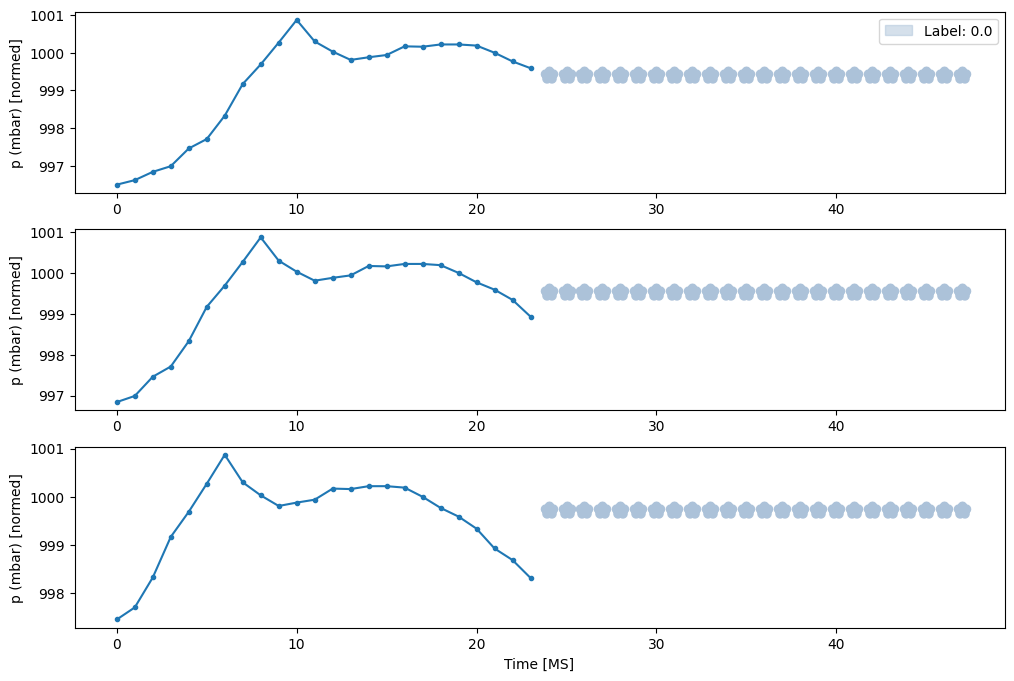

In [17]:
w1.plot()

In [18]:
def make_cohort(self, data:np.array) -> tf.data.Dataset:
    data = np.array(data, dtype=np.float32)
    ds = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=self.batch_size
    )
    ds = ds.map(self.split_window)
    return ds

MultiSeriesWindowsGenerator.make_cohort = make_cohort

In [19]:
w1.make_cohort(series_1.set_index(GROUPBY + [DATE]))

<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [20]:
"""
Reference code from https://stackoverflow.com/questions/49994496/mixing-multiple-tf-data-dataset
"""

def stack_windows(*windows):
    features = tf.concat([window[0] for window in windows], 0)
    labels = tf.concat([window[1] for window in windows], 0)
    return (features, labels)

def make_dataset(self, data:tf.Tensor) -> tf.data.Dataset:
    # num_cohorts = min(10, len(cluster_cohorts))
    # print(cluster, num_cohorts)
    ds_list = tuple(self.make_cohort(data[i]) for i in range(len(data)))
    ds = tf.data.Dataset.zip(ds_list)
    ds = ds.map(stack_windows)
    ds = ds.unbatch()
    ds = ds.shuffle(10, seed=0)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(1)
    return ds

MultiSeriesWindowsGenerator.make_dataset = make_dataset


In [21]:
w1.make_dataset(w1.train_df)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [22]:
@property
def train(self) -> tf.data.Dataset:
    return self.make_dataset(self.train_df)

@property
def val(self) -> tf.data.Dataset:
    return self.make_dataset(self.val_df)

@property
def test(self) -> tf.data.Dataset:
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting"""
    result = getattr(self, '_example', None)
    # print('Number of train batches:', len(list(self.train.as_numpy_iterator())))
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result

MultiSeriesWindowsGenerator.train = train
MultiSeriesWindowsGenerator.test = test
MultiSeriesWindowsGenerator.val = val
MultiSeriesWindowsGenerator.example = example

In [23]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 24, 3)
Labels shape (batch, time, features): (8, 24, 1)


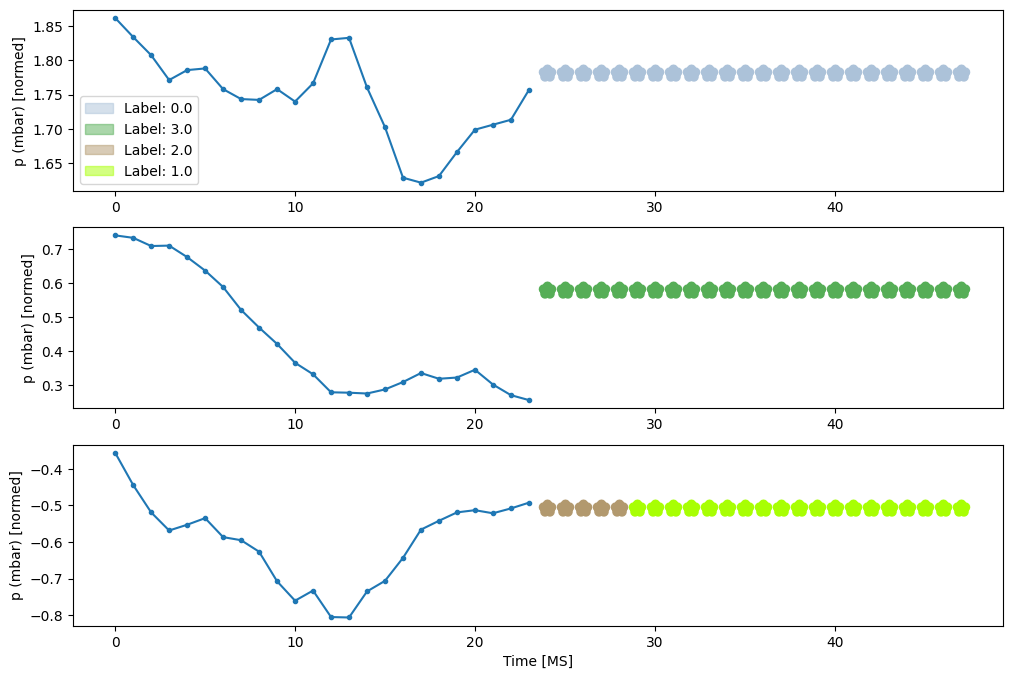

In [24]:
w1.plot()

# Baseline models

In [25]:
single_step_window = MultiSeriesWindowsGenerator(
    input_width=1, label_width=1, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY, label_columns=LABELS, regressor_columns=REGRESSORS)
single_step_window.update_datasets(train_series, val_series, test_series, norm=True)

In [26]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    result = tf.one_hot(tf.cast(result, tf.int32), depth=4)
    return result

In [27]:
baseline = Baseline(label_index=single_step_window.column_indices[LABELS[0]])

baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy())

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5253/5253 [==============================] - 15s 3ms/step - loss: 1.3912


In [28]:
wide_window = MultiSeriesWindowsGenerator(
    input_width=24, label_width=24, shift=1, batch_size=BATCH_SIZE, GROUPBY = GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS)
wide_window.update_datasets(train_series, val_series, test_series, norm=True)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Batch Size: 8
Label column name(s): ['T (degC)']
Additional Regressor column name(s): ['p (mbar)', 'rh (%)']
GROUPBY column(s): ['SeriesID']

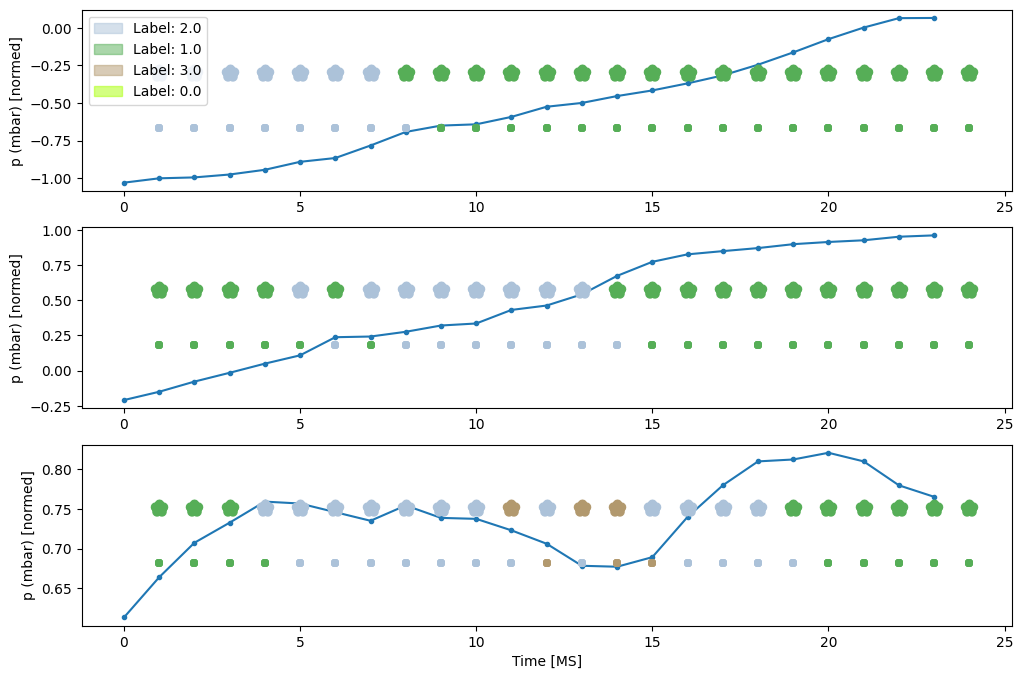

In [29]:
wide_window.plot(baseline)

# Done with the changes :)